# Distributional Semantics with Neural Networks

Distributional semantics has become popular with the work of Mikolov, who uses artificial neural networks in the CBOW and Skip Gram Models to compute dense word embeddings. These simple models in fact have only two layers. Thus there is nothing realy deep, and I would hesitate to call it deep learning. It is also not clear whether the models are really better than the count based models. Nevertheless: the idea is very clever and the model is quite efficient and effective.

It is very easy to use  vectors trained by Google or Microsoft. It is also easy to train your own vectors with a free implementation of the model. However, just to learn a bit more about the models it is also usefull to implement the network with libraries liek TensorFlow or Keras. In the followin we will implement the Skip Gram Model using Keras.

We will use the same data for training and evaluation used in the previous notebook. 



## Data

We use a corpus of 300k sentences from wikipedia collected by the university of Leipzig. You can download the required data from http://wortschatz.uni-leipzig.de/en/download/ . The file used here is **deu_wikipedia_2016_300K-sentences**

### Reading the Corpus

The texts in the corpus are already split into sentences. We read thes sentence and word-tokenize each sentence. To save time we use the infected words and do not do anly lemmatization or stemming.

In [2]:
import codecs
import nltk

sentences = []

#Caution: change the path to this file!
quelle = codecs.open(r'C:\Users\hp\Desktop\natural language processing\eng_wikipedia_2016_300K\eng_wikipedia_2016_300K-sentences.txt','r','utf8')
for line in quelle:
    nr,satz = line.split('\t')
    sentences.append(nltk.word_tokenize(satz.strip()))

In [8]:
from collections import Counter

wortfrequenz = Counter()

for satz in sentences:
    wortfrequenz.update(satz)

vocabulary  = [w for w,f in wortfrequenz.items() if 30 < f < 3000]
vocabulary_size = len(vocabulary)
print(vocabulary_size)
print(vocabulary[1:40])

14638
['device', 'must', 'respond', 'address', 'cycle', 'command', 'codes', 'problem', 'similar', 'dynamic', 'programming', 'solution', 'runs', 'population', 'Hispanic', 'Latino', 'race', '1000', 'Millennium', 'page', '42', '1999', 'According', 'Hobbes', 'sovereign', 'control', 'civil', 'military', 'judicial', 'ecclesiastical', 'powers', 'grade', 'fuel', 'night', 'fighters', 'intercept', '100', 'BC', '*']


Next we want to know, what words are most similar to a given word. To do so, we need to compare a word with each other word in the list. We use an ordered list to store the results. Since these list always sort ascending, we need to consider always the last elements of this list. Finallye, we return the results in inverse order.

We copy the functions for testing and evaluating from the previous notebook

In [9]:
import bisect 

def most_similar(word,vectors,n):
    best = []
    vec_w = vectors[word]
    for z in vectors:
        if z == word:
            continue
        sim = vec_w.dot(vectors[z])

        #we have to add this result only, if we do not yet have n results, or if the similarity is larger than the similarity with the last element in the list (actually the first since we sort ascending)
        if len(best) < n or sim > best[0][0]:
            bisect.insort(best,(sim,z))
            best = best[-n:]
       
    return best[::-1] #present the list in descending order

In [11]:
import math
testfile = codecs.open('../../TMNB/Corpora/wortpaare350.gold.pos.txt','r','utf8')
testfile.readline()

testdata = []
missing = set()
for line in testfile:
    w1,w2,sim,p1,p2 = line.split(':')
    if w1 in vocabulary and w2 in vocabulary:
        testdata.append((w1,w2,float(sim)))
    
def evaluate(data,vectors):
    gold = []
    predicted = []
    for v,w,sim in data:
        pred = vectors[v].dot(vectors[w])

        gold.append(sim)
        predicted.append(pred)
        #print(v,w,pred,sim,sep = '\t')
        
    
    av_p = sum(predicted)/len(predicted)
    av_g = sum(gold)/len(gold)
    
    cov = 0
    var_g = 0
    var_p = 0
    for s,t in zip(gold,predicted):
        cov += (s-av_g) * (t-av_p)
        var_g += (s-av_g) * (s-av_g)
        var_p += (t-av_p) * (t-av_p)
        
    return cov / math.sqrt(var_g*var_p)

# Skip Gram with Keras

### Set some parameter values

In [104]:
embedding_size = 100
window_size = 2

### Preparing the data

We will give each word (type) an id and replace all tokens by their ids. We do this for words in the vocabulary we want to consider. We simply remove all other words. 

For the skip gram model w need pairs of a word and a context word. We will build a list of such pairs before we start the training

We will not use subsamplin for two reasons:
1. We want to keep the model as simple and basic as possible
2. We remove all high frequent words completely from the data. Thus the effect of subsampling well be very small for our data.

In [105]:
word2id = {w:vocabulary.index(w) for w in vocabulary}

def make_skipgram_data(sents,window):
    x = []
    y = []
    
    for sent in sents:
        for i in range(len(sent)):
            w = sent[i]
            if w not in word2id: 
                continue
            for j in range(max(0,i-window),min(len(sent),i+window+1)):
                if i == j:
                    continue
                cw = sent[j]
                if cw not in word2id: 
                    continue
                x.append(word2id[w])
                y.append(word2id[cw])
    return x,y
            
sgdata, sglabels = make_skipgram_data(sentences,window_size)

In [106]:
len(sgdata)

2397718

Now we can build and train a Keras model with an embedding layer and a softmax layer.

This takes quite long. Usually word embeddings are trained with a lot of data, but the number of epochs is kept very low, often just one epoch is used.

Since the quality of the embedings drops very fast with large batch sizes, we have to keep the batches small. In most implementations no batches are used at all and gradienst are computed after every example. To speed up things little bit, we will use batches nevertheless.

Negative sampling is not easy to use in a Keras sequential model. Thus we will use all negative words and Categorical Cross-entopy as loss function. The Sparse Categorical Cross-entropy implementation from tensor flow can just take one number as input and use it as if it is a one hot encoded vector.

In [12]:
import tensorflow as tf 
import numpy as np

def mag(x):
    return np.sqrt(x.dot(x))

def make_vectors_sg(inputwords,outputwords,w2id):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocabulary_size, embedding_size,name = "embedding"),
        tf.keras.layers.Dense(vocabulary_size, activation='softmax'), 
    ])

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam') 
    model.summary()
    model.fit(inputwords, outputwords, shuffle=False, batch_size = 256, epochs=5)

    #now we need to do some work to get the weights out of the layer
    embed_layer = model.get_layer(name = "embedding")
    id_embeddings = embed_layer.get_weights()[0]

    word_embeddings = {}
    for word in w2id:
        wid = w2id[word]
        vect = id_embeddings[wid]
        word_embeddings[word] = vect /mag(vect)
    return word_embeddings

KeyboardInterrupt: 

In [108]:
vectors_sg = make_vectors_sg(sgdata,sglabels,word2id)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1216500   
_________________________________________________________________
dense_18 (Dense)             (None, None, 12165)       1228665   
Total params: 2,445,165
Trainable params: 2,445,165
Non-trainable params: 0
_________________________________________________________________
Train on 2397718 samples
Epoch 1/5
2397718/2397718 [==============================] - 1875s 782us/sample - loss: 8.3235
Epoch 2/5
2397718/2397718 [==============================] - 1079s 450us/sample - loss: 7.6781
Epoch 3/5
2397718/2397718 [==============================] - 843s 352us/sample - loss: 7.3976
Epoch 4/5
2397718/2397718 [==============================] - 862s 359us/sample - loss: 7.2386
Epoch 5/5
2397718/2397718 [==============================] - 856s 357us/sample - loss: 7.1369


In [109]:
most_similar('Garten',vectors_sg,10)

[(0.56055343, 'Haus'),
 (0.5159907, 'Gartens'),
 (0.4907197, 'Altar'),
 (0.48452988, 'Pfarrhaus'),
 (0.4789636, 'Grundstück'),
 (0.47842243, 'Gruft'),
 (0.4675786, 'Saal'),
 (0.46742553, 'Wohnhaus'),
 (0.45853272, 'Hütte'),
 (0.45598, 'Herrenhaus')]

In [110]:
most_similar('betrachten',vectors_sg,10)

[(0.507598, 'Würde'),
 (0.4931266, 'verstanden'),
 (0.4777692, 'erfüllt'),
 (0.46733052, 'Helden'),
 (0.46498412, 'betrachtet'),
 (0.4533536, 'durchgesetzt'),
 (0.4483814, 'pflegen'),
 (0.44216532, 'individuelle'),
 (0.4334458, 'vernachlässigt'),
 (0.43333393, 'sexuelle')]

In [111]:
most_similar('Schweden',vectors_sg,10)

[(0.66450083, 'Finnland'),
 (0.6193092, 'Norwegen'),
 (0.5225931, 'Russland'),
 (0.5073995, 'Ungarn'),
 (0.5053329, 'Marokko'),
 (0.504759, 'Rumänien'),
 (0.49721742, 'Dänemark'),
 (0.49059206, 'Italien'),
 (0.48612812, 'Sizilien'),
 (0.4845919, 'Frankreich')]

In [112]:
most_similar('Direktor',vectors_sg,10)

[(0.76334065, 'Leiter'),
 (0.6727679, 'Vizepräsident'),
 (0.6538635, 'Geschäftsführer'),
 (0.6321034, 'Chefredakteur'),
 (0.6215431, 'Vorsitzender'),
 (0.61665684, 'Redakteur'),
 (0.6058444, 'Vorstand'),
 (0.5865274, 'Mitbegründer'),
 (0.5771582, 'Rektor'),
 (0.5762267, 'Präsidentin')]

It is more interesing to find the most similar word if we have more words to choose from. Let us collect some mid-frequency words to do so.

In [113]:
evaluate(testdata,vectors_sg)

0.5498503665831492

# Using the Gensim Word2Vec implementation

Implementing word embeddings ourselves is usefull to get an understanding of the models. If we just want to use the embeddings, we can use a standard implementation.

For the following we do not use optimal parameters, but sick to the same values as used above and in the count based models.

In [114]:
import gensim 

gensim_model = gensim.models.Word2Vec(sentences, min_count=30, window=2,size = 100,sg=1,negative=20)

We used the following paraeters:
* min_count: all words with lee than 30 occurrences are ignored
* window: the windowsize for co-occurrence
* size: number of dimensions of the embedding layer
* sg: Use skip gram. Use 0 for cbow
* negative: number of negative samples

For an overview of all parameters see: https://radimrehurek.com/gensim/models/word2vec.html

In [115]:
print(gensim_model.wv.similarity('Kirche','Kloster'))
print(gensim_model.wv.similarity('Kirche','Schweden'))
print(gensim_model.wv.similarity('Deutschland','Schweden'))

0.6361296
0.34710714
0.6896317


In [116]:
gensim_model.wv.most_similar(positive=['Garten'], topn=10)

[('Gasthof', 0.8020752668380737),
 ('Pavillon', 0.801609218120575),
 ('Landhaus', 0.7893657684326172),
 ('Vorort', 0.7869713306427002),
 ('Restaurant', 0.7789061665534973),
 ('Zirkus', 0.7738268971443176),
 ('Wohngebiet', 0.7713614702224731),
 ('Eingangsbereich', 0.7703713178634644),
 ('Palast', 0.7646967768669128),
 ('Saal', 0.7643088102340698)]

In [117]:
gensim_model.wv.most_similar(positive=['betrachten'], topn=10)

[('integrieren', 0.8898133039474487),
 ('pflegen', 0.8680932521820068),
 ('verstehen', 0.8669787645339966),
 ('bewerten', 0.8662629127502441),
 ('erleben', 0.8588632345199585),
 ('gestalten', 0.857586145401001),
 ('identifizieren', 0.8563686609268188),
 ('beseitigen', 0.8558042049407959),
 ('akzeptieren', 0.8479902744293213),
 ('gewähren', 0.847662627696991)]

In [118]:
gensim_model.wv.most_similar(positive=['Schweden'], topn=10)

[('Finnland', 0.8420255184173584),
 ('Rumänien', 0.8200536370277405),
 ('Bulgarien', 0.8182411789894104),
 ('Frankreich', 0.8167185187339783),
 ('Serbien', 0.8061835765838623),
 ('Norwegen', 0.8032677173614502),
 ('Slowenien', 0.7985612154006958),
 ('Dänemark', 0.7982602119445801),
 ('Kroatien', 0.7959966659545898),
 ('Ungarn', 0.7911868691444397)]

In [119]:
gensim_model.wv.most_similar(positive=['Direktor'], topn=10)

[('Leiter', 0.8615671396255493),
 ('Dekan', 0.8523338437080383),
 ('Vorstandsmitglied', 0.8387725949287415),
 ('Generaldirektor', 0.8299515247344971),
 ('Geschäftsführer', 0.8273563385009766),
 ('Vorsitzender', 0.8176326751708984),
 ('Generalsekretär', 0.8121423721313477),
 ('Sekretär', 0.8112099170684814),
 ('Vizepräsident', 0.8110094666481018),
 ('Chefredakteur', 0.8065465688705444)]

The word embeddings from gesim are not normalize to the length 1, as we need for the evaluation function. Thus we build our own dictionay of length normalized vectors:

In [120]:
vectors_gensim = {w:gensim_model.wv[w]/mag(gensim_model.wv[w]) for w in vocabulary}

In [121]:
evaluate(testdata,vectors_gensim)

0.4383009152019232

It seems that our quite naive implementation gave better results than the gensim implementation. However, be awar that:
    1. We have to search for optimal parameters
    2. One small test set in fact doesn't tell  us a lot
    3. The training time of our algorithm was extremelz long compared to the training time of the Gensim model.

# Some fun!

A vraint of the function most_similar gives the words closest to some constructed vector

In [122]:
def close_words(vector,vectors,n):
    best = []
    for z in vectors:
        sim = vector.dot(vectors[z])

        #we have to add this result only, if we do not yet have n results, or if the similarity is larger than the similarity with the last element in the list (actually the first since we sort ascending)
        if len(best) < n or sim > best[0][0]:
            bisect.insort(best,(sim,z))
            best = best[-n:]
       
    return best[::-1] #present the list in descending order

In [175]:
v = vectors_gensim["sehen"] - vectors_gensim["Auge"]   + vectors_gensim["Ohr"] 
v = v /mag(v)
close_words(v,vectors_gensim,5)

[(0.8601551, 'sehen'),
 (0.7665867, 'hören'),
 (0.6946947, 'besichtigen'),
 (0.69001675, 'schreiben'),
 (0.6884777, 'erleben')]

In [167]:
v = vectors_gensim["Deutschland"] - vectors_gensim["Berlin"]   + vectors_gensim["London"] 
v = v /mag(v)
close_words(v,vectors_gensim,5)

[(0.7821288, 'Deutschland'),
 (0.76385, 'Japan'),
 (0.7379942, 'Europa'),
 (0.71775895, 'England'),
 (0.71146977, 'Großbritannien')]

In [168]:
v = vectors_sg["Deutschland"] - vectors_sg["Berlin"] + vectors_sg["London"] 
v = v /mag(v)
close_words(v,vectors_sg,5)

[(0.6715543, 'Deutschland'),
 (0.598994, 'England'),
 (0.53210276, 'London'),
 (0.4486238, 'Süddeutschland'),
 (0.43323925, 'Italien')]

## Reduce 100 Dimensions to 2 and display

First collect 50 nice words

In [126]:
nice_words = [w for w,f in wortfrequenz.items() if 200 < f < 250 and 6 < len(w) < 10 and w[0].isupper()]
len(nice_words)

85

C:\Users\wartena\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.
C:\Users\wartena\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


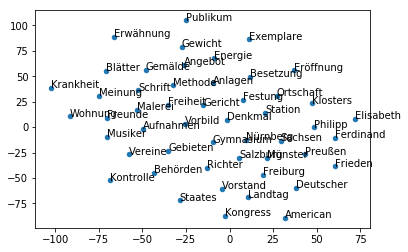

In [127]:
labels = []
count = 0
max_count = 50
X = np.zeros(shape=(max_count, len(gensim_model['Leiter'])))

for term in nice_words:
    X[count] = gensim_model[term]
    labels.append(term)
    count+= 1
    if count >= max_count: 
        break

# It is recommended to use PCA first to reduce to ~50 dimensions
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
X_50 = pca.fit_transform(X)

# Using TSNE to further reduce to 2 dimensions
from sklearn.manifold import TSNE
model_tsne = TSNE(n_components=2, random_state=0)
Y = model_tsne.fit_transform(X_50)

# Show the scatter plot
import matplotlib.pyplot as plt
plt.scatter(Y[:,0], Y[:,1], 20)

# Add labels
for label, x, y in zip(labels, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy = (x,y), xytext = (0, 0), textcoords = 'offset points', size = 10)

plt.show()